# Bookies Odds Evaluation

In this notebook, we will analyse how accurately bookmaker odds predict English Premier League (EPL) match outcomes. The main goal is to determine the level of performance our model needs to achieve in order to "beat the bookies."

In [28]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from scipy.stats import spearmanr, ttest_ind
from sklearn.metrics import roc_curve, auc

In [2]:
plt.style.use('ggplot')

In [3]:
sys.path.append(os.path.abspath(os.path.join("../")))
from src.ingestion import get_data_fduk

In [4]:
SL = 0.05 # significance_level

## Data Prep

We will use historical data from [football-data.co.uk](https://football-data.co.uk) for this analysis. Note that we will remove records for which no odds exist, which occur in the firts two seasons present in the dataset.

To correct the implied probabilities, we will divide each probability by the sum of the implied probabilities for a home win, draw, and away win. This adjustment removes the bookmakers' margin, ensuring that the probabilities sum to 1. By doing this, we obtain a clearer picture of how well the underlying model performs.

In [5]:
COLUMNS = [
    "season",
    "date",
    "home_team",
    "away_team",
    "goals_h",
    "goals_a",
    "result",
    "odds_h_b365",
    "odds_d_b365",
    "odds_a_b365"
]

In [6]:
data = get_data_fduk(
    seasons=range(0, 25),
    leagues=["E0"],
    columns=COLUMNS,
    enrich=True
)

2025-03-04 20:44:43.589 | INFO     | src.ingestion:get_data_fduk:82 - Sucessfully loaded data for E0 in 00_01
2025-03-04 20:44:43.803 | INFO     | src.ingestion:get_data_fduk:82 - Sucessfully loaded data for E0 in 01_02
2025-03-04 20:44:43.996 | INFO     | src.ingestion:get_data_fduk:82 - Sucessfully loaded data for E0 in 02_03
2025-03-04 20:44:44.195 | INFO     | src.ingestion:get_data_fduk:86 - Error loading data for E0 in 03_04: Error tokenizing data. C error: Expected 57 fields in line 305, saw 72

2025-03-04 20:44:44.411 | INFO     | src.ingestion:get_data_fduk:86 - Error loading data for E0 in 04_05: 'utf-8' codec can't decode byte 0xa0 in position 75614: invalid start byte
2025-03-04 20:44:45.059 | INFO     | src.ingestion:get_data_fduk:82 - Sucessfully loaded data for E0 in 05_06
2025-03-04 20:44:45.917 | INFO     | src.ingestion:get_data_fduk:82 - Sucessfully loaded data for E0 in 06_07
2025-03-04 20:44:46.169 | INFO     | src.ingestion:get_data_fduk:82 - Sucessfully loaded da

In [7]:
data = data.rename(columns={
    "odds_h_b365": "odds_h",
    "odds_d_b365": "odds_d",
    "odds_a_b365": "odds_a"
})

In [8]:
nan_stats = data.groupby('season').apply(lambda x: x.isna().sum(), include_groups=False).reset_index()
nan_stats = nan_stats.sort_values(['odds_h', 'odds_d', 'odds_a'], ascending=False)
nan_stats.head()

,season,date,home_team,away_team,goals_h,goals_a,result,odds_h,odds_d,odds_a,game_num_h,game_num_a,season_half_h,season_half_a
0,00_01,0,0,0,0,0,0,380,380,380,0,0,0,0
1,01_02,0,0,0,0,0,0,380,380,380,0,0,0,0
12,14_15,1,1,1,1,1,1,1,1,1,0,0,0,0
2,02_03,0,0,0,0,0,0,0,0,0,0,0,0,0
3,05_06,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
data = data.dropna(subset=['odds_h', 'odds_d', 'odds_a']).reset_index()

## Bookmaker's Margin

Converting bookmaker odds into probabilities using the formula $P = \frac{1}{\text{odds}}$ typically yields a sum that exceeds 1. This phenomenon, known as the overround, is a deliberate adjustment built into the odds to ensure that the bookmaker earns a profit regardless of the outcome. The excess—i.e., the amount by which these probabilities exceed $100\%$—is called the margin, representing the bookmaker’s expected profit percentage if the bets are perfectly balanced.

Whilst bookmakers set their initial odds using their own models, they will then continuously adjust these odds based on where the money is wagered. This strategy is known as the balanced book principle. Essentially, bookmakers aim to encourage a balanced distribution of bets across all outcomes. If too many bets are placed on one outcome, they will lower the odds (and thus the potential payout) for that outcome, while increasing the odds for the less favored outcomes to attract more bets there. The objective is to have the total amount wagered on each outcome reflect the associated risk, so that regardless of which outcome occurs, the total payout to winning bettors remains less than the overall stakes collected. This mechanism not only helps manage risk but also reinforces the bookmaker's profit, as the built-in margin is preserved even when betting is skewed.


In [10]:
implied_probs_h = 1 / data.loc[:, 'odds_h']
implied_probs_d = 1 / data.loc[:, 'odds_d']
implied_probs_a = 1 / data.loc[:, 'odds_a']

data['margin'] = (implied_probs_h) + (implied_probs_d) + (implied_probs_a) - 1

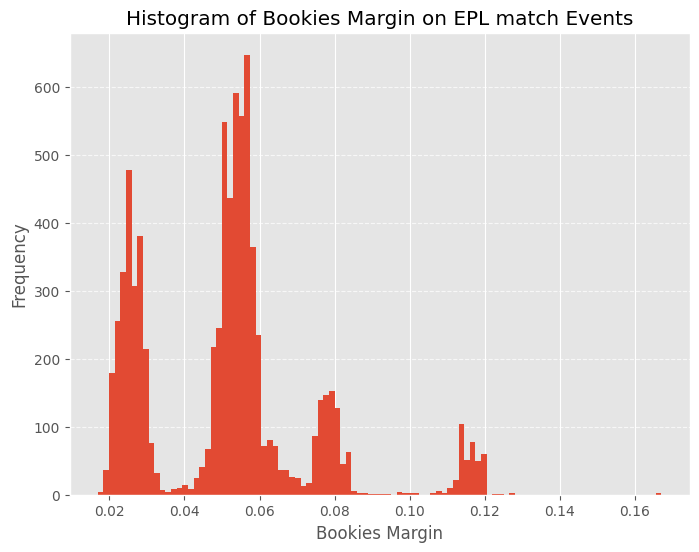

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(data['margin'], bins=100)

plt.xlabel("Bookies Margin")
plt.ylabel("Frequency")
plt.title("Histogram of Bookies Margin on EPL match Events")
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()

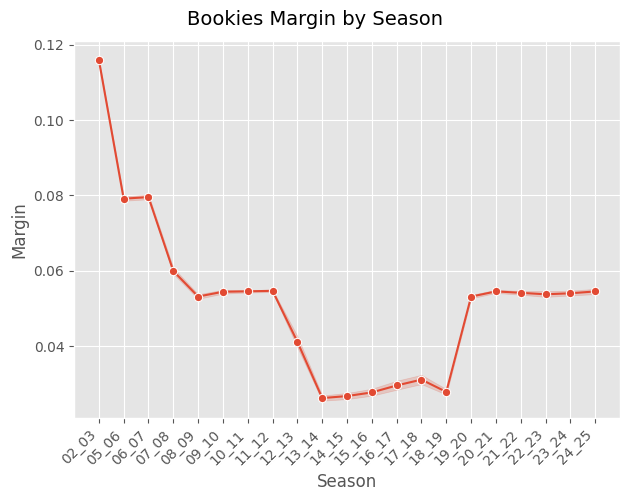

In [12]:
sns.lineplot(data=data, x="season", y="margin", estimator=np.mean, marker="o")
plt.title('')
plt.xlabel('Season')
plt.ylabel('Margin')

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.xticks(rotation=45, ha='right')
plt.suptitle('Bookies Margin by Season', fontsize=14)
plt.show()

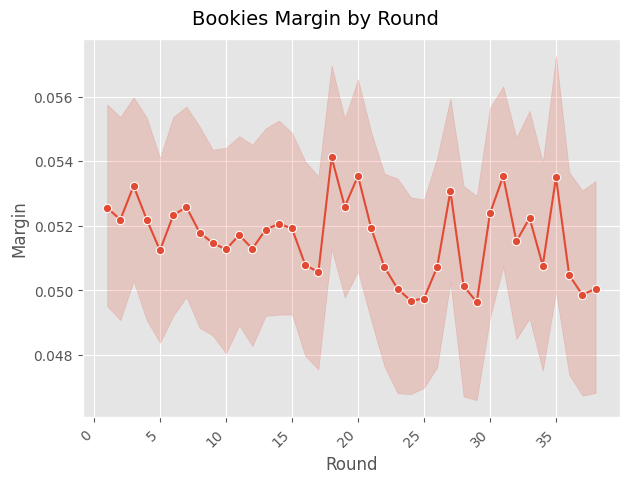

In [13]:
sns.lineplot(data=data, x="game_num_h", y="margin", estimator=np.mean, marker="o")
plt.title('')
plt.xlabel('Round')
plt.ylabel('Margin')

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.xticks(rotation=45, ha='right')
plt.suptitle('Bookies Margin by Round', fontsize=14)
plt.show()

To accurately assess the performance of the bookmaker's "model," we first convert the odds back into valid probability measures. Since the original implied probabilities sum to $1 + \text{margin}$ due to the overround, we normalize them by dividing by $1 + \text{margin}$. This normalization provides a true probability distribution that we can use to benchmark future models.

However, it's important to remember that simply outperforming the bookmaker's baseline model is not sufficient to beat the bookies in practice—we must exceed their model’s accuracy by enough to overcome the inherent profit margin.


In [14]:
data['prob_h'] = 1 / data['odds_h'] / (1 + data['margin'])
data['prob_d'] = 1 / data['odds_d'] / (1 + data['margin'])
data['prob_a'] = 1 / data['odds_a'] / (1 + data['margin'])

## Brier Score

First, we examine the Brier score, which rewards well-calibrated probabilities. We will compute the overall Brier score for the model as a whole, treating it as a three-class classifier. Additionally, to fully understand how well-calibrated the odds are, we will calculate the individual Brier scores for home win, draw, and away win separately—essentially treating the model as three binary classifiers. Each of these four scores will be computed at the game level, allowing us to group by season and round to analyse how accuracy and calibration change over time.

In [15]:
def spearman_test(x, y, sig):
    corr, p = spearmanr(x, y)

    if p < sig:
        direction = "Negative" if corr < 0 else "Positive"
        print(f"Significant {direction} Trend - Correlation: {corr}")
    else:
        print("No Significant Correlation")

In [16]:
def one_sided_t_test(group1, group2, sig):
    _, p = ttest_ind(group1, group2, equal_var=False, alternative='less')  

    if p < sig:
        print(f"Score for group1 is significantly Less Than group2")
    else:
        print("No Significant Difference Found")

In [17]:
data['brier_score_h'] = (data['prob_h'] - (data['result'] == 'H').astype(int)) ** 2
data['brier_score_d'] = (data['prob_d'] - (data['result'] == 'D').astype(int)) ** 2
data['brier_score_a'] = (data['prob_a'] - (data['result'] == 'A').astype(int)) ** 2
data['brier_score_t'] = data['brier_score_h'] + data['brier_score_d'] + data['brier_score_a']

### Brier Score by Season

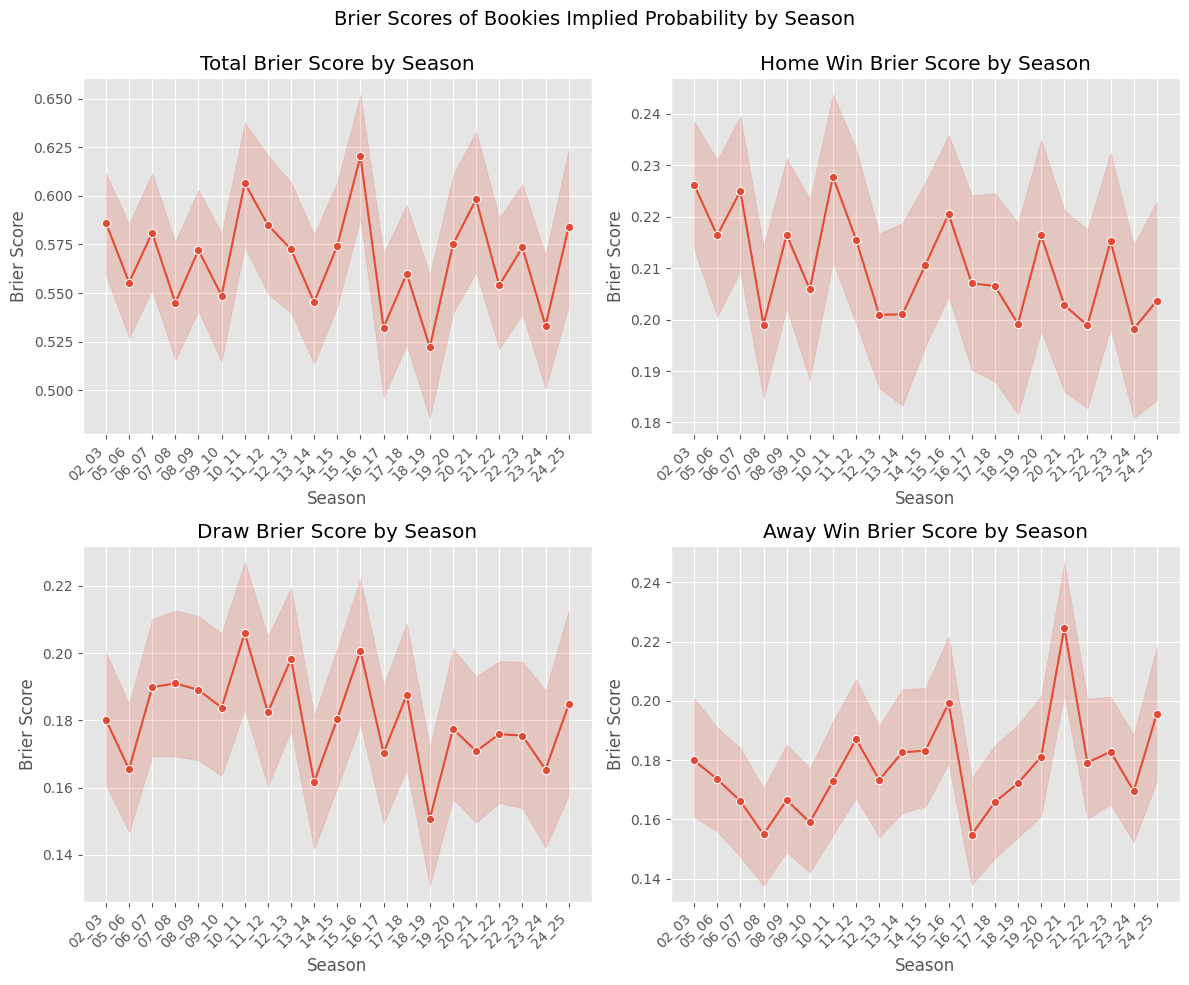

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
result_groups = ['total', 'home win', 'draw', 'away win']

for ax, res in zip(axes.flatten(), result_groups):
    sns.lineplot(data=data, x="season", y=f"brier_score_{res[0]}", ax=ax, estimator=np.mean, marker="o")
    ax.set_title(f'{res.title()} Brier Score by Season')
    ax.set_xlabel('Season')
    ax.set_ylabel('Brier Score')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.suptitle('Brier Scores of Bookies Implied Probability by Season', fontsize=14)
plt.show()

In [19]:
print("Bookies Implied Probability by Season\n\n")
for res in result_groups:
    print(f"{res.title()} Brier Score: ")
    spearman_test(data['season'], data[f'brier_score_{res[0]}'], SL / 4)
    print("\n")

Bookies Implied Probability by Season


Total Brier Score: 
No Significant Correlation


Home Win Brier Score: 
Significant Negative Trend - Correlation: -0.06297768183128882


Draw Brier Score: 
Significant Negative Trend - Correlation: -0.13381399929699433


Away Win Brier Score: 
Significant Positive Trend - Correlation: 0.0358855555478785




The results indicate a significant trend of improvement in the bookmakers' odds for predicting home wins and draws. However, there is a significant deterioration in predictive performance for away wins. Despite these individual trends, the overall performance of the model as a three-class classifier does not exhibit a significant trend over time.

It is important to note that while these trends are statistically significant, their magnitudes are weak, as evidenced by the visual analysis presented above.

### Brier Score by Round

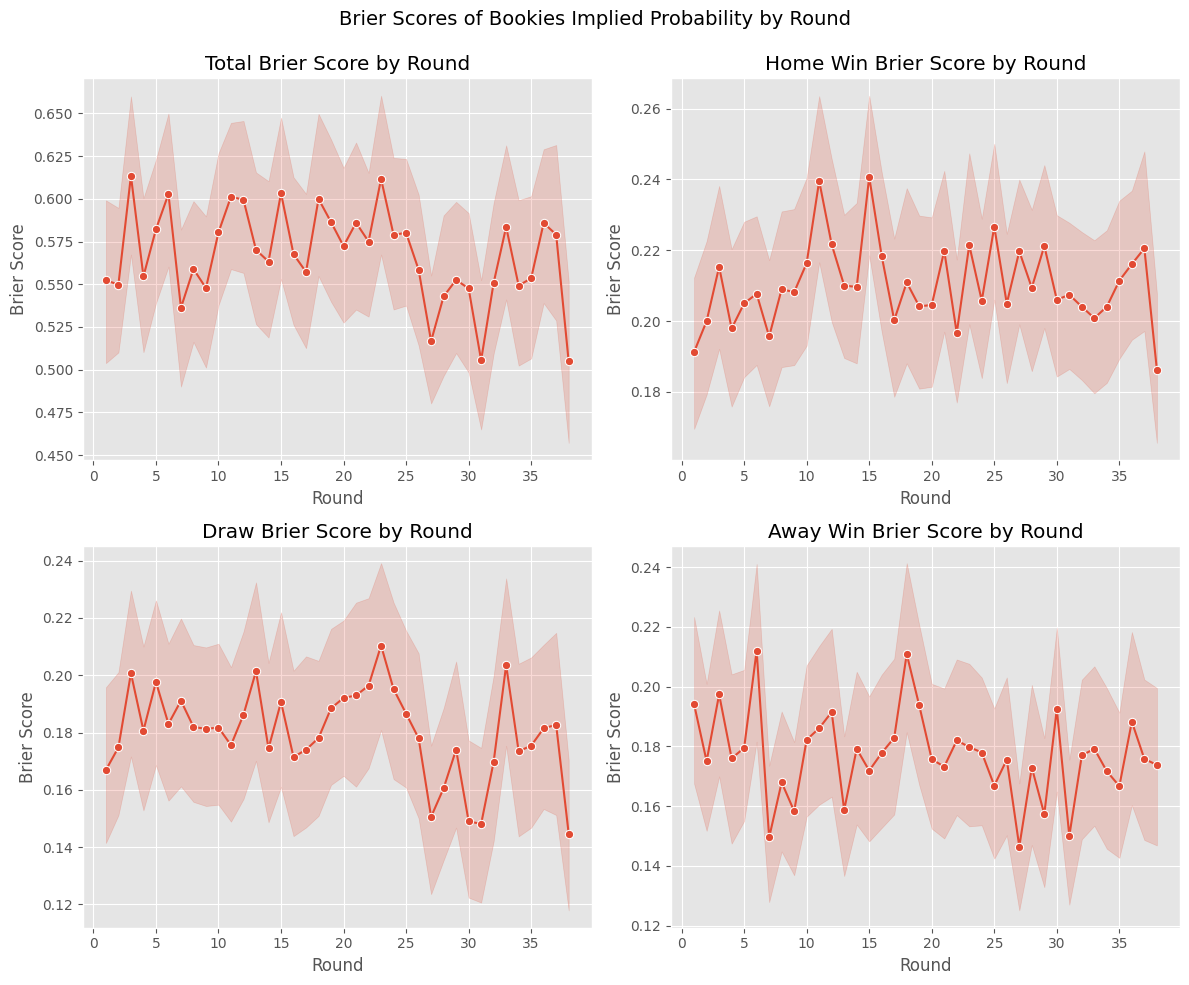

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, res in zip(axes.flatten(), result_groups):
    sns.lineplot(data=data, x="game_num_h", y=f"brier_score_{res[0]}", ax=ax, estimator=np.mean, marker="o")
    ax.set_title(f'{res.title()} Brier Score by Round')
    ax.set_xlabel('Round')
    ax.set_ylabel('Brier Score')
    ax.set_xticks(np.arange(data["game_num_h"].min() - 1, 
                     data["game_num_h"].max(), 5))

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.suptitle('Brier Scores of Bookies Implied Probability by Round', fontsize=14)
plt.show()

In [21]:
print("Bookies Implied Probability by Round \n\n")
for res in result_groups:
    print(f"{res.title()} Brier Score: ")
    spearman_test(data['game_num_h'], data[f'brier_score_{res[0]}'], SL / 4)
    print("\n")

Bookies Implied Probability by Round 


Total Brier Score: 
No Significant Correlation


Home Win Brier Score: 
No Significant Correlation


Draw Brier Score: 
Significant Negative Trend - Correlation: -0.037380135687028054


Away Win Brier Score: 
No Significant Correlation




In [22]:
final_round_data = data.loc[data['game_num_h'] == 38]
non_final_round_data = data.loc[data['game_num_h'] != 38]

print("Bookies Implied Probability for Round 38 (group1) vs Rest of Season (group2) \n\n")
for res in result_groups:
    print(f"{res.title()} Brier Score: ")
    one_sided_t_test(final_round_data[f"brier_score_{res[0]}"], non_final_round_data[f"brier_score_{res[0]}"], SL / 4)
    print("\n")

Bookies Implied Probability for Round 38 (group1) vs Rest of Season (group2) 


Total Brier Score: 
Score for group1 is significantly Less Than group2


Home Win Brier Score: 
No Significant Difference Found


Draw Brier Score: 
Score for group1 is significantly Less Than group2


Away Win Brier Score: 
No Significant Difference Found




There is a significant negative trend in the Brier score for the draw binary classifier as seasons progress, indicating that the bookmakers' odds are increasingly well-calibrated for predicting draws over time during a given season. However, no such trend is observed for home wins, away wins, or the three-class model as a whole.

Additionally, for the three-class model, there is a significant decrease in the Brier score for the final game of the season compared to the rest of the season. This sharp drop is also evident in the visuals above.

## Probability Calibration

We will now examine graphical representations of how well-calibrated the predicted probabilities are overall. Specifically, we will look at calibration curves, which plot the predicted probabilities against the observed frequencies of the positive class. For a perfectly calibrated model, this should resemble a straight $y=x$ line.

A notable pitfall of calibration curves is that extreme probabilities (close to $0$ or $1$) are often poorly represented, leading to increased noise in these regions due to limited data points. To address this, we also plot a quantile calibration graph, which bins predictions into equally sized quantiles and plots the average predicted probability against the actual observed frequency of positive cases. This approach helps smooth out noise and provides a clearer view of calibration performance.

In [23]:
def plot_calibration_curve(
        data: pd.DataFrame, 
        result: str, 
        n_bins: int
) -> None:
    r = result[0].lower()
    R = result[0].upper()
    result = result if result.lower() == 'draw' else result + ' win'
    result = result.title()

    y_true = (data['result'] == R).astype(int)
    y_prob = data[f'prob_{r}']

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve", color='b')
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration", color='gray')

    plt.xlabel(f"Bookies {result} Probability")
    plt.ylabel(f"Proportion of {result}s")
    plt.title(f"Calibration Curve of Bookies Implied Probability for {result}")
    plt.legend()
    plt.grid(True)

    plt.show()


In [24]:
def plot_quantile_calibration(
        data: pd.DataFrame, 
        result: str,
        n_bins: int
) -> None:
    r = result[0].lower()
    R = result[0].upper()
    result = result if result.lower() == 'draw' else result + ' win'
    result = result.title()

    y_true = (data['result'] == R).astype(int)
    y_prob = data[f'prob_{r}']


    sorted_indices = np.argsort(y_prob)
    y_prob_sorted = y_prob[sorted_indices]
    y_test_sorted = y_true[sorted_indices]

    bin_edges = np.linspace(0, len(y_prob), n_bins + 1, dtype=int)

    prob_true = []
    prob_pred = []
    bin_labels = []

    for i in range(n_bins):
        start, end = bin_edges[i], bin_edges[i + 1]
        bin_probs = y_prob_sorted[start:end]
        bin_true = y_test_sorted[start:end]

        prob_true.append(np.mean(bin_true))
        prob_pred.append(np.mean(bin_probs))  
        bin_labels.append(f"{prob_pred[-1]:.4f}")  

    plt.figure(figsize=(8, 6))
    plt.bar(bin_labels, prob_true, color='b', alpha=0.7, label="Quantile Calibration")

    plt.plot(bin_labels, prob_pred, marker='o', linestyle="--", color='r', label="Perfect Calibration")

    plt.xlabel(f"Bookies {result} Probability bin")
    plt.ylabel(f"Proportion of {result}s")
    plt.title(f"Quantile Calibration Graph of Bookies Implied Probability for {result}")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle="--", alpha=0.7)

    plt.show()

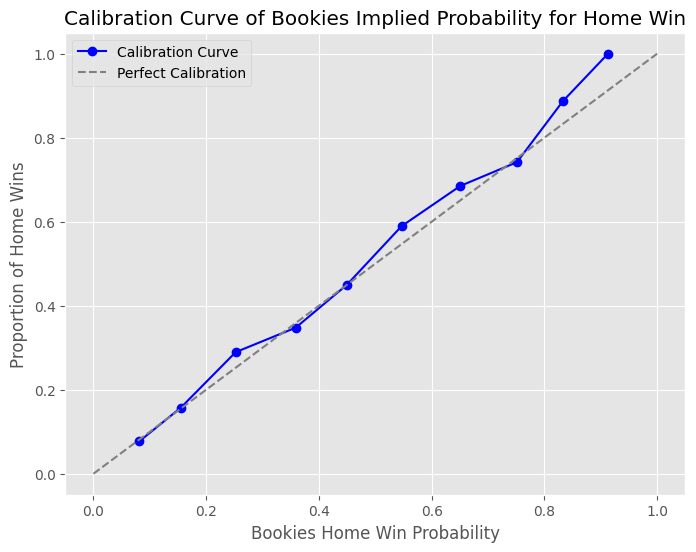

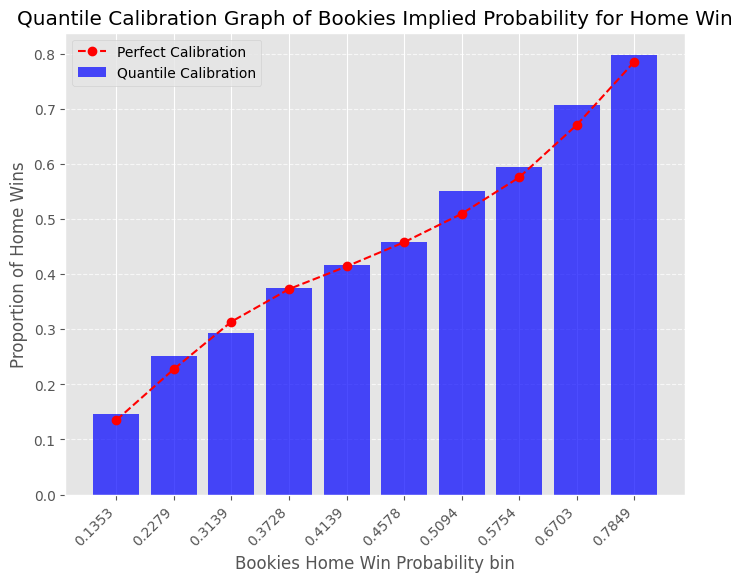

In [25]:
plot_calibration_curve(data, 'home', 10)
plot_quantile_calibration(data, 'home', 10)

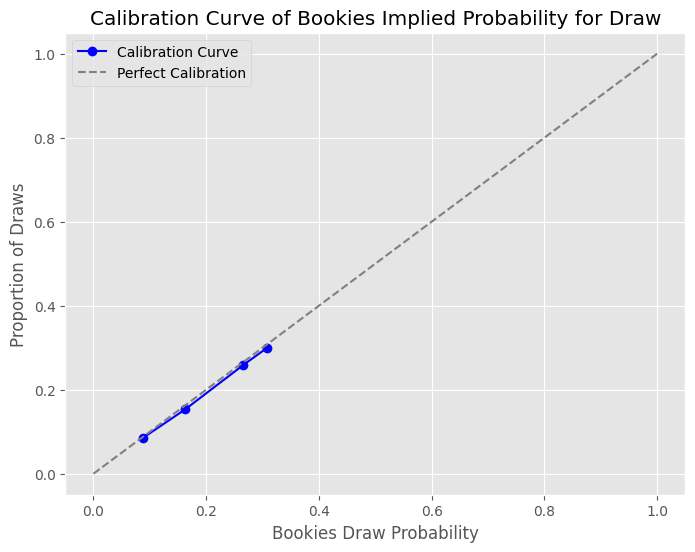

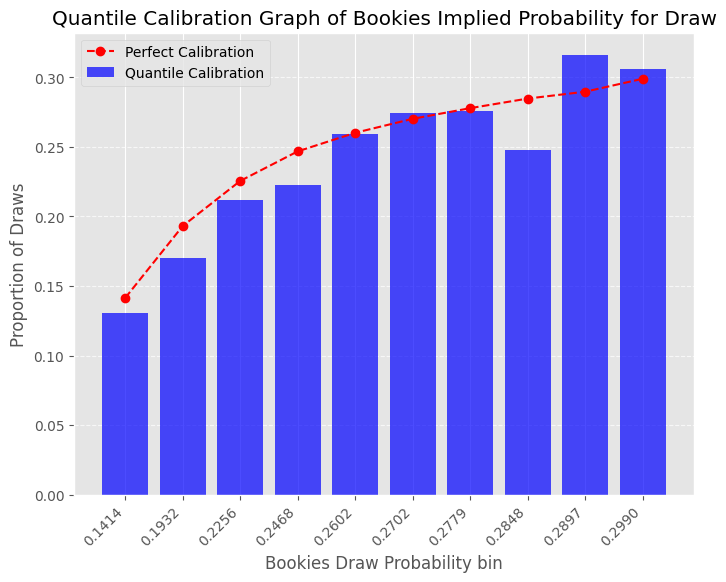

In [26]:
plot_calibration_curve(data, 'draw', 10)
plot_quantile_calibration(data, 'draw', 10)

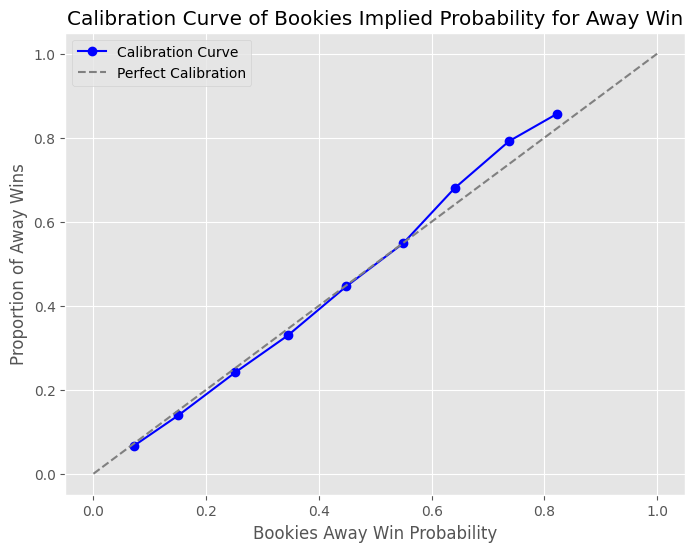

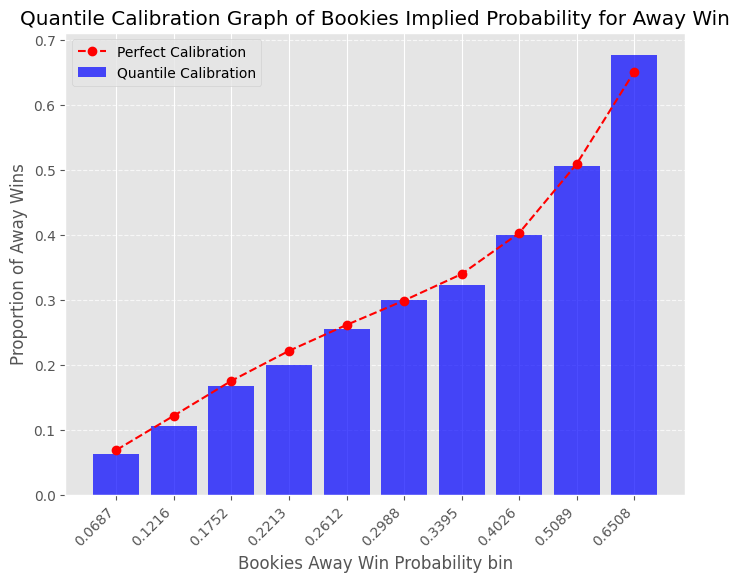

In [27]:
plot_calibration_curve(data, 'away', 10)
plot_quantile_calibration(data, 'away', 10)

## ROC Curve

Although our primary goal is to optimize models for well-calibrated probabilities, the ROC curve remains a valuable tool. Typically used to assess a model's discriminative ability, the ROC curve can also offer insights into the level of aleatoric uncertainty in our predictions. When aleatoric uncertainty is low, predicted probabilities tend to be more extreme—closer to 0 or 1—making it easier to choose thresholds that yield higher true positive rates. 

We will inspect the ROC curve of the bookies odds for home win, draw and loss by treating the model as three seperate binary classifiers again.

###### Note: This perspective on the ROC curve interprets the shape of the curve as being influenced by inherent uncertainty in the predictions, an approach that complements traditional views of the ROC as a measure of discriminative performance.

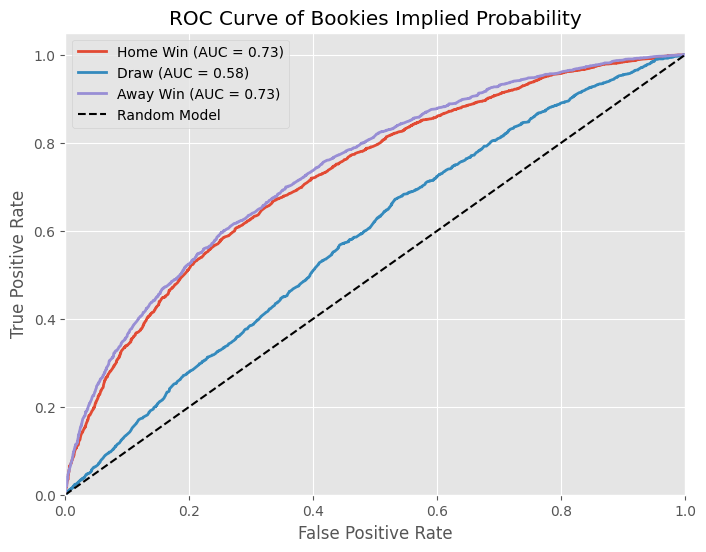

In [38]:
plt.figure(figsize=(8, 6))

fpr_h, tpr_h, _ = roc_curve((data['result'] == 'H').astype(int), data[f'prob_h'])
roc_auc_h = auc(fpr_h, tpr_h)
plt.plot(fpr_h, tpr_h, label=f'Home Win (AUC = {roc_auc_h:.2f})', linewidth=2)

fpr_d, tpr_d, _ = roc_curve((data['result'] == 'D').astype(int), data[f'prob_d'])
roc_auc_d = auc(fpr_d, tpr_d)
plt.plot(fpr_d, tpr_d, label=f'Draw (AUC = {roc_auc_d:.2f})', linewidth=2)

fpr_a, tpr_a, _ = roc_curve((data['result'] == 'A').astype(int), data[f'prob_a'])
roc_auc_a = auc(fpr_h, tpr_h)
plt.plot(fpr_a, tpr_a, label=f'Away Win (AUC = {roc_auc_a:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve of Bookies Implied Probability")
plt.legend()
plt.show()

This notebook can now serve as a base set of references to the performance of bookies odds, and we may add to this over time.